# Image generation from scratch

In [597]:
import numpy as np
from skimage.draw import line_aa
import matplotlib.pyplot as plt

In [673]:
def generate_imgs(N, n_samples, margin_tb_min=0.05, margin_tb_max=0.20,
                  displacement_y_max=0.20, difference_y_max=0.15):
    '''
    Function for generating training data + test data.
    Currently produces images of arrows pointing upwards.
    '''
    
    # Store images in this ndarray
    imgs = np.zeros((n_samples, N, N), dtype=np.uint8)
    
    # Generate one sample at a time
    for i in range(n_samples):
        # Generate line thickness
        line_thickness = min(0.25, np.random.random(1)/2)

        # Generate x-values
        x0 = margin_tb_min + np.random.random(1)*(margin_tb_max - margin_tb_min)
        x1 = 1 - margin_tb_min - np.random.random(1)*(margin_tb_max - margin_tb_min)

        # Generate y-values
        displacement = (2*np.random.random(1)-1)*displacement_y_max
        difference = (2*np.random.random(1)-1)*difference_y_max

        # Generate y-values
        y0 = 0.5 + displacement - difference/2
        y1 = 0.5 + displacement + difference/2

        # Calculate position of tips
        x_m = (3*x0+x1)/4
        y_m = (3*y0+y1)/4
        # Tip 1
        x_t1 = x_m - (y0-y_m)
        x_t2 = x_m + (y0-y_m)
        # Tip 2
        y_t1 = y_m + (x0-x_m) 
        y_t2 = y_m - (x0-x_m)

        # Convert proportions to pixel values in the image
        X0 = int(N*x0 + 0.5)
        X1 = int(N*x1 + 0.5)
        Y0 = int(N*y0 + 0.5)
        Y1 = int(N*y1 + 0.5)
        XT1 = int(N*x_t1 + 0.5)
        YT1 = int(N*y_t1 + 0.5)
        XT2 = int(N*x_t2 + 0.5)
        YT2 = int(N*y_t2 + 0.5)

        # Add main line in the arrow
        rr, cc, val = line_aa(X0, Y0, X1, Y1)
        imgs[i,rr,cc] = val > line_thickness

        # Add extra lines to make an actual arrow
        rr, cc, val = line_aa(X0, Y0, XT1, YT1)
        imgs[i,rr,cc] = val > line_thickness
        rr, cc, val = line_aa(X0, Y0, XT2, YT2)
        imgs[i,rr,cc] = val > line_thickness
        
    return imgs



def add_noise(imgs, prob):
    '''
    Add noise to random pixels in the image.
    '''
    noise = np.random.binomial(1, prob, imgs.shape)
    
    return np.bitwise_xor(imgs, noise)

    
    
def create_data(N, n_samples, noise_prob = 0, flatten=False):
    '''
    Fuction for creating the actual training data w/ labels.
    '''
    # Generate imgs
    imgs = generate_imgs(N, n_samples)
    
    # Add noise
    if noise_prob > 0:
        imgs = add_noise(imgs, noise_prob)
    
    # Generate labels (0 = up, 1 = left, 2 = down, 3 = right)
    labels = np.random.randint(4, size=n_samples, dtype=np.uint8)
    
    # Rotate images according to their label
    for i in (1,2,3):
        imgs[labels==i] = np.rot90(imgs[labels==i], k=i, axes=(1,2))
    
    # If flatten is true, images are returned as 1D instead of 2D
    if flatten:
        return labels, imgs.reshape(n_samples, N*N)
    return labels, imgs



def visualize(imgs, n_samples):
    '''
    Function for visualizing the images
    '''
    N = imgs.shape[1]
    fig, axes = plt.subplots(1, n_samples, figsize=(N, N))
    for i, ax in enumerate(axes.flat):
        ax.imshow( imgs[i].reshape(N,N), cmap='Greys' )
        ax.set_xlabel('t')
        ax.set_axis_off()
    plt.show()

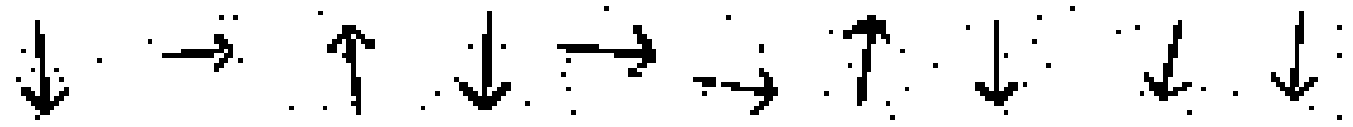

In [693]:
labels, imgs = create_data(N = 24, n_samples = 100, noise_prob=0.01)
visualize(imgs, 10)

In [835]:
x = np.random.random((5,8))
t = x + 0.1

In [851]:
mse_der(x, t)

array([[-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
       [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
       [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
       [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
       [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04]])

In [849]:
def x_entropy(x, t):
    """Compute cross entropy for each column in x."""
    return - np.sum(t * np.log(x), axis=0)

def x_entropy_der(x, t):
    """Compute derivative of cross entropy for each column in x."""
    return - t/x

def mse(x, t):
    """Compute mean squared error for each column in x."""
    return np.mean((x-t)**2, axis=0)

def mse_der(x, t):
    """Derivative of mean squared error for each column in x."""
    ncol = x.shape[0]
    return 2*(x - t) / ncol
    

In [819]:
def softmax(x):
    """Compute softmax values for each column in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def softmax_der(s):
    """Compute the derivative of ONE softmaxed column."""
    # note: s = softmax(x)
    return np.diag(s) - np.outer(s,s)

In [820]:
x = 0.1*np.arange(12).reshape(3,4)
s = softmax(x)